In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import h5py
import os
import sys
import datetime
import csv

import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import logging
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

# For visualize input
from torch.utils.tensorboard import SummaryWriter
import io
import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from PIL import Image

class EEGDataset(Dataset):
    '''
    Custom Dataset object for PyTorch to load the dataset
    '''
    def __init__(self, x, y, train, val):
        super(EEGDataset).__init__()
        assert x.shape[0] == y.size
        self.x = x
        self.y = [y[i][0] for i in range(y.size)]
        self.train = train
        self.val = val

    def __getitem__(self,key):
        return (self.x[key], self.y[key])

    def __len__(self):
        return len(self.y)

class Logger():
    '''
    Object controlling how information will be logged
    A logger created globally will be used to log all information
    Create a Logger(mode='debug') to have everything print to the console
    '''
    def __init__(self, mode='log'):
        self.mode = mode
        
    def set_model_save_location(self, model_dir):
        self.model_dir = f"saved-model/{model_dir}"
        if not os.path.isdir(self.model_dir):
            os.mkdir(self.model_dir)
        
    def set_experiment(self, experiment_name):
        self.experiment_name = experiment_name
        log_format = '%(asctime)s %(message)s'
        logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                            format=log_format, datefmt='%m/%d %I:%M:%S %p')
        fh = logging.FileHandler(os.path.join('training-logs', f'log-{experiment_name}-{datetime.datetime.today()}.txt'))
        fh.setFormatter(logging.Formatter(log_format))
        logging.getLogger().addHandler(fh)
        self.writer = SummaryWriter(f"runs/{experiment_name}")
            
    def log(self, message=""):
        if self.mode == 'log':
            logging.info(message)
        elif self.mode == 'debug':
            print(message)

    def save_model(self, model, info):
        torch.save(model.state_dict(), f"{self.model_dir}/model-{logger.experiment_name}-{info}")
        
def load_data(path, role, winLength, numChan, srate, feature, one_channel=False, version=""):
    """
    Load dataset
    :param  
        path: Filepath to the dataset
        role: Role of the dataset. Can be "train", "val", or "test"
        winLength: Length of time window. Can be 2 or 15
        numChan: Number of channels. Can be 24 or 128
        srate: Sampling rate. Supporting 126Hz
        feature: Input feature. Can be "raw", "spectral", or "topo"
        one_channel: Whether input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
        version: Any additional information of the datafile. Will be appended to the file name at the end
    """
    transform = T.Compose([
        T.ToTensor()
    ])
    if version:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    x = f[f'X_{role}']
    if feature == 'raw':
        x = np.transpose(x,(0,2,1))
        x = np.reshape(x,(-1,1,numChan,winLength*srate))
    elif feature == 'topo':
        if one_channel:
            samples = []
            for i in range(x.shape[0]):
                image = x[i]
                b, g, r = image[0,:, :], image[1,:, :], image[2,:, :]
                concat = np.concatenate((b,g,r), axis=1)
                samples.append(concat)
            x = np.stack(samples)
            x = np.reshape(x,(-1,1,x.shape[1],x.shape[2]))
    
    if version:
        f = h5py.File(path + f"child_mind_yclass1_ages_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_yclass1_ages_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    y = np.subtract(f[f'Y_cls_{role}'], 1)
   
    return x,y



def plot_to_image_tensor(figure):
    # Save the plot to a PNG in memory.
    figure.savefig('batch.png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    img = Image.open('batch.png')
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    image_tensor = trans1(img)
    return image_tensor

def plot_EEG(data, feature, numChan, one_channel=True):
    '''
    Plot EEG sample
    :param
        data: An EEGDataset object
        feature: String - 'raw' or 'topo'
        numChan: Int - number of EEG channels
        one_channel: Bool - Whether input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
    '''
    x_data = data[:][0]
    if feature == 'raw':        
        fig = plt.figure(figsize=(80, 80))
        outer = gridspec.GridSpec(8, 8)
        for i in range(64):
            inner = gridspec.GridSpecFromSubplotSpec(numChan, 1,
                            subplot_spec=outer[i])
#             npimg = img[i,:,:,:].numpy()
            npimg = x_data[i,:,:,:]
            npimg = np.reshape(npimg,(24,256))
            yax = None
            for j in range(24):
                ax = plt.Subplot(fig, inner[j])
                ax.plot(range(256),npimg[j,:],'k')
                ax.set_xticks([])
                ax.set_yticks([])
                fig.add_subplot(ax)

        return fig
    else:
        sample = 2
        if one_channel:
            image = np.reshape(x_data[sample], (x_data[sample].shape[1],x_data[sample].shape[2]))
            plt.imshow(image.astype('int32'))
        else:
            plt.imshow(np.transpose(x_data[sample].astype('int32'), (1, 2, 0)))
        plt.show()

In [2]:
# Load EEG data
path = './data/'
winLength = 2
numChan = 24
srate = 128
feature = 'raw'
one_channel = False

role = 'train'
train_data_x, train_data_labels = load_data(path, role, winLength, numChan, srate, feature, one_channel)
# print(f'X_train shape: {len(train_data)}, {train_data[0][0].shape}')
# print(f'Y_train shape: {len(train_data)}, {train_data[0][1].shape}')

role = 'val'
val_data_x, val_data_labels = load_data(path, role, winLength, numChan, srate, feature, one_channel)
# print(f'X_val shape: {len(val_data)}, {val_data[0][0].shape}')
# print(f'Y_val shape: {len(val_data)}, {val_data[0][1].shape}')
# EEGDataset(x, y, role=='train', role=='val')
# plot_EEG(train_data, feature, numChan, one_channel)

In [3]:
train_data_y = train_data_labels.copy()
train_data_y[np.logical_and(train_data_labels <= 2,train_data_labels >= 0)] = 0
train_data_y[train_data_labels > 2] = 1
val_data_y = val_data_labels.copy()
val_data_y[np.logical_and(val_data_labels <= 2,val_data_labels >= 0)] = 0
val_data_y[val_data_labels > 2] = 1

(array([43597.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 27784.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

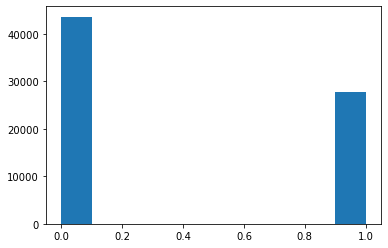

In [4]:
plt.hist(train_data_y)

In [59]:
43597/(43597+27784)

0.610764769336378

(array([24980.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 14888.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

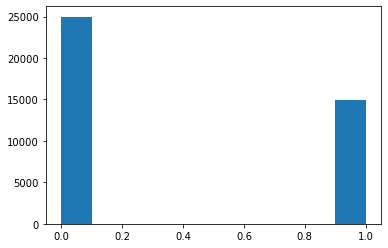

In [57]:
plt.hist(val_data_y)

In [61]:
24980/(24980+14888)

0.6265676733219625

In [58]:
train_data = EEGDataset(train_data_x, train_data_y, True, False)
val_data = EEGDataset(val_data_x, val_data_y, False, True)

In [71]:
# Initialize device information for PyTorch
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [72]:
def check_accuracy(loader, model):
    '''
    Check accuracy of the model 
    param:
        loader: An EEGDataset object
        model: A PyTorch Module to test
    '''
    if loader.dataset.train:
        logger.log('Checking accuracy on training set')
    elif loader.dataset.val:
        logger.log('Checking accuracy on validation set')
    else:
        logger.log('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            scores = model(x)
#             print(f"label {y}, prediction {scores}")
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        logger.log('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

In [69]:
def train(model, loader_train, loader_val, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    params:
        model: A PyTorch Module giving the model to train.
        loader_train: A PyTorch DataLoader object containing training data loaded in batch
        loader_val: A PyTorch DataLoader object containing validation data loaded in batch        
        optimizer: An Optimizer object we will use to train the model
        epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
#     mseLoss = nn.MSELoss()
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
#             y = y.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
#             loss = mseLoss(scores, y)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                logger.writer.add_scalar("Loss/train", loss.item(), e*len(loader_train)+t)
                logger.log('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        train_acc = check_accuracy(loader_train, model)
        logger.writer.add_scalar("Acc/train", train_acc, e)        
        val_acc = check_accuracy(loader_val, model)
        logger.writer.add_scalar("Acc/valid", val_acc, e)        
        logger.log()
        
        # Save model every 20 epochs
        if e > 0 and e % 10 == 0:
            logger.save_model(model,f"epoch{e}")
        elif val_acc >= 0.7:
            logger.save_model(model,f"valacc70-epoch{e}")
        elif val_acc >= 0.71:
            logger.save_model(model,f"valacc71-epoch{e}")
    # save final model
    logger.save_model(model,f"epoch{e}")
    return model

In [106]:
train_data_x = train_data_x.reshape((71381, 24, 256))
val_data_x = val_data_x.reshape((39868, 24, 256))

In [99]:
train_data.shape()

AttributeError: 'EEGDataset' object has no attribute 'shape'

In [5]:
import tensorflow as tf
print(f"tf version={tf.__version__}")
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils
from tensorflow.keras import backend as K

tf version=1.14.0


In [110]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(24, 256)))
model.add(MaxPooling1D(2, 2, padding='same'))
model.add((Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')))
model.add(MaxPooling1D(2, 2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add((Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')))
model.add(MaxPooling1D(2, 2, padding='same'))
model.add((Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')))
model.add(MaxPooling1D(2, 2, padding='same'))
model.add(BatchNormalization())
model.add((Dropout(0.3)))

model.add(LSTM(256))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_41 (Conv1D)           (None, 24, 64)            49216     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 12, 64)            12352     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 6, 64)             0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 6, 64)             256       
_________________________________________________________________
dropout_49 (Dropout)         (None, 6, 64)             0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 6, 128)          

In [10]:
model.fit(train_data_x, train_data_y, batch_size=64, epochs=50, validation_data=(val_data_x, val_data_y), shuffle=True)

Train on 71381 samples, validate on 39868 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
71381/71381 [==============================] - 34s 478us/sample - loss: 9.8340 - acc: 0.3896 - val_loss: 10.0991 - val_acc: 0.3734
Epoch 2/50
71381/71381 [==============================] - 32s 446us/sample - loss: 9.8444 - acc: 0.3892 - val_loss: 10.0991 - val_acc: 0.3734
Epoch 3/50
71381/71381 [==============================] - 32s 447us/sample - loss: 9.8444 - acc: 0.3892 - val_loss: 10.0991 - val_acc: 0.3734
Epoch 4/50
15104/71381 [=====>........................] - ETA: 20s - loss: 9.7718 - acc: 0.3937

KeyboardInterrupt: 

In [149]:
val_pred = model.predict(val_data_x)

In [151]:
val_pred = [p[0]<p[1] for p in val_pred]

In [152]:
val_pred[:5]

[False, False, False, False, False]

In [6]:
train_data_x = np.swapaxes(train_data_x, 1, 3)
train_data_x = np.swapaxes(train_data_x, 1, 2)
train_data_x.shape

(71381, 24, 256, 1)

In [7]:
val_data_x = np.swapaxes(val_data_x, 1, 3)
val_data_x = np.swapaxes(val_data_x, 1, 2)

In [8]:
train_data_y = tf.keras.utils.to_categorical(train_data_y)
val_data_y = tf.keras.utils.to_categorical(val_data_y)

In [9]:
model = Sequential()
model.add(Conv2D(100, 3, activation='relu', input_shape=(24, 256, 1)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Conv2D(100, 3, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Conv2D(300, (2, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Conv2D(300, (1, 7), activation='relu'))
model.add(MaxPooling2D((1, 2), 1))
model.add(Dropout(0.25))
model.add(Conv2D(100, (1, 3), activation='relu'))
model.add(Conv2D(100, (1, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(6144, activation="relu"))
model.add(Dense(2, activation="relu"))

adam = keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 254, 100)      1000      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 127, 100)      0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 127, 100)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 125, 100)       90100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 62, 100)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 62, 100)        0         
____

In [63]:
def create_model():
    '''
    Create the CNN following configuration in van Putten et al. (2018)
    '''
    model = nn.Sequential(
            nn.Conv2d(1,100,3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(100,100,3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(100,300,(2,3)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(300,300,(1,7)),
            nn.ReLU(),
            nn.MaxPool2d((1,2), stride=1),
            nn.Dropout(0.25),
            nn.Conv2d(300,100,(1,3)),
            nn.ReLU(),
            nn.Conv2d(100,100,(1,3)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1900,6144),
            nn.ReLU(),
            nn.Linear(6144,2),
        )
    return model
#     feature = 'raw'
#     subsample = 4
#     tmp = models.vgg16()
#     tmp.features = tmp.features[0:17]
#     vgg16_rescaled = nn.Sequential()
#     modules = []
    
#     if feature == 'raw':
#         first_in_channels = 1
#         first_in_features = 6144
#     else:
#         first_in_channels = 3
#         first_in_features = 576
        
#     for layer in tmp.features.children():
#         if isinstance(layer, nn.Conv2d):
#             if layer.in_channels == 3:
#                 in_channels = first_in_channels
#             else:
#                 in_channels = int(layer.in_channels/subsample)
#             out_channels = int(layer.out_channels/subsample)
#             modules.append(nn.Conv2d(in_channels, out_channels, layer.kernel_size, layer.stride, layer.padding))
#         else:
#             modules.append(layer)
#     vgg16_rescaled.add_module('features',nn.Sequential(*modules))
#     vgg16_rescaled.add_module('flatten', nn.Flatten())

#     modules = []
#     for layer in tmp.classifier.children():
#         if isinstance(layer, nn.Linear):
#             if layer.in_features == 25088:
#                 in_features = first_in_features
#             else:
#                 in_features = int(layer.in_features/subsample) 
#             if layer.out_features == 1000:
#                 out_features = 2
#             else:
#                 out_features = int(layer.out_features/subsample) 
#             modules.append(nn.Linear(in_features, out_features))
#         else:
#             modules.append(layer)
#     vgg16_rescaled.add_module('classifier', nn.Sequential(*modules))
#     return vgg16_rescaled

In [20]:
!pip install pytorch-model-summary

In [64]:
# Create and show model summary
model = create_model()
#from pytorch_model_summary import summary
#print(summary(model, torch.zeros((1, 1, 24, 256)), show_input=False))

In [60]:
def test_model(model, test_data, subj_csv):
    '''
    Test model using two different metrics. First is per sample accuracy.
    Second is to use 40 samples per subject and perform voting:
        If mean prediction > 0.5, classify as female (1)
        Otherwise, classify as male (0)
    param:
        model: A trained PyTorch Module
        test_data: test dataset
        subj_csv: spreadsheet containing subject IDs for the test dataset
    '''
    # one-segment test
    logger.log('Testing model accuracy using 1-segment metric')
    loader_test = DataLoader(test_data, batch_size=70)
    per_sample_acc = check_accuracy(loader_test, model)

    # 40-segment test
    logger.log('Testing model accuracy using 40-segment per subject metric')
    with open(subj_csv, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        subjIDs = [row[0] for row in spamreader]
    unique_subjs,indices = np.unique(subjIDs,return_index=True)

    iterable_test_data = list(iter(DataLoader(test_data, batch_size=1)))
    num_correct = []
    for subj,idx in zip(unique_subjs,indices):
    #     print(f'Subj {subj} - gender {iterable_test_data[idx][1]}')
        data = iterable_test_data[idx:idx+40]
        #print(np.sum([y for _,y in data]))
        assert 40 == np.sum([y for _,y in data]) or 0 == np.sum([y for _,y in data])
        preds = []
        correct = 0
        with torch.no_grad():
            for x,y in data:
                x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
                correct = y
                scores = model(x)
                _, pred = scores.max(1)
                preds.append(pred)
        final_pred = (torch.mean(torch.FloatTensor(preds)) > 0.5).sum()
        num_correct.append((final_pred == correct).sum())
    #print(len(num_correct))
    acc = float(np.sum(num_correct)) / len(unique_subjs)
    logger.log('Got %d / %d correct (%.2f)' % (np.sum(num_correct), len(unique_subjs), 100 * acc))
    return per_sample_acc, acc

In [68]:
def run_experiment(seed, model_name, feature, loader_train, loader_val, num_epoch):
    '''
    Train a model for num_epoch given a random seed. 
    During training, logs and intemediary models will be saved in files accordingly to model_name
    param:
        seed: Int - Random seed number
        model_name: String - Name of the model to be saved. Used for logging
        feature: String - Whether 'raw' or 'topo'
        loader_train: DataLoader with training set
        loader_val: DataLoader with validation set
        num_epoch: Int - number of epoch to train the model
    '''
    model = create_model()
    logger.set_model_save_location(f'{model_name}-{feature}')
    experiment = f'{model_name}-{feature}-seed{seed}'
    logger.set_experiment(experiment)

    np.random.seed(seed)
    torch.manual_seed(seed)

    # toggle between learning rate and batch size values 

    optimizer = torch.optim.Adamax(model.parameters(), lr=0.002)
    model = train(model, loader_train, loader_val, optimizer, epochs=num_epoch)
    
    # Testing
    logger.log('Testing on balanced test set')
    test_data_balanced = load_data(path, 'test', winLength, numChan, srate, feature)
    sample_acc1, subject_acc1 = test_model(model, test_data_balanced, path + 'test_subjIDs_fewer_subjects.csv')

    logger.log('Testing on all-male test set')
    test_data_all_male = load_data(path, 'test', winLength, numChan, srate, feature,'v3')
    sample_acc2, subject_acc2 = test_model(model, test_data_all_male, path + 'test_subjIDs_more_test.csv')
    
    return model

In [24]:
torch.empty(3, dtype=torch.long).random_(5)

tensor([3, 2, 4])

In [73]:
# train model multiple times, each with different random seed
logger = Logger() # initialize logger to be used throughout

batch_size = 256
loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=batch_size)
for s in range(1):
    model = run_experiment(s, 'original-ages-classification', 'raw',loader_train, loader_val,70)
# model = run_experiment(9, 'original', 'raw',70)

RuntimeError: Given groups=1, weight of size 100 1 3, expected input[256, 24, 256] to have 1 channels, but got 24 channels instead

In [51]:
test_data_x, test_data_labels = load_data(path, 'test', winLength, numChan, srate, feature, one_channel)
test_data_y = test_data_labels.copy()
test_data_y[np.logical_and(test_data_labels <= 2,test_data_labels >= 0)] = 0
test_data_y[test_data_labels > 2] = 1
test_data = EEGDataset(test_data_x, test_data_y, False, False)

In [19]:
model.load_state_dict(torch.load('./saved-model/original-ages-classification-raw/model-original-ages-classification-raw-seed0-valacc70-epoch49'))

<All keys matched successfully>

In [20]:
logger = Logger(mode='debug')
loader_test = DataLoader(test_data, batch_size=1)
model.to(device=device)
check_accuracy(loader_test, model)

Checking accuracy on test set
Got 11501 / 15925 correct (72.22)


0.7221978021978022

(array([8797.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7128.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

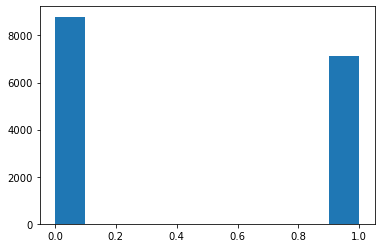

In [21]:
plt.hist(test_data_y)

In [22]:
8797/(8797+7128)

0.5524018838304553

In [ ]:
def test_all_seeds(partial_model_path, epoch, num_seed, isBalanced=True):
    '''
    Given name of saved model and epoch, check test accuracy for all random seeds in range(num_seed)
    
    '''
    if isBalanced:
        logger.log('Testing on balanced test set')
        test_data = load_data(path, 'test', winLength, numChan, srate, feature,'v2')
        subjIDs_file = 'data/test_subjIDs_fewer_subjects.csv'
    else:
        logger.log('Testing on all male test set')
        test_data = load_data(path, 'test', winLength, numChan, srate, feature,'v3')
        subjIDs_file = 'data/test_subjIDs_more_test.csv'

    sample_acc = []
    subject_acc = []
    for s in range(num_seed):
        model = create_model()
        model.load_state_dict(torch.load(f'{partial_model_path}-seed{s}-epoch{epoch}'))
        model.to(device=device)
        sam_acc, sub_acc = test_model(model, test_data,subjIDs_file)
        sample_acc.append(sam_acc)
        subject_acc.append(sub_acc)
        
    sample_acc = np.multiply(sample_acc,100)
    subject_acc = np.multiply(subject_acc,100)
    return sample_acc, subject_acc

In [12]:
logger = Logger(mode='debug')
# Compute test performance statistics for all intermidiary saved-models at each specified epochs
# and save result to a csv file
epochs = [40, 50, 60, 69]

with open("original-relu-raw-test-results-balanced.csv", 'w') as out:
    out.write('epoch,min_sam,max_sam,mean_sam,std_sam,min_subj,max_subj,mean_subj,std_subj\n')
    for epoch in epochs:
        sample_acc, subject_acc = test_all_seeds(partial_model_path="saved-model/original-relu-raw/model-original-relu-raw", epoch=epoch, num_seed=10, isBalanced=True)

        min_sample = np.min(sample_acc)
        max_sample = np.max(sample_acc)
        mean_sample = np.mean(sample_acc)
        std_sample = np.std(sample_acc)

        min_subj = np.min(subject_acc)
        max_subj = np.max(subject_acc)
        mean_subj = np.mean(subject_acc)
        std_subj = np.std(subject_acc)

        logger.log("Per sample")
        logger.log(f"Min: {min_sample}, Max: {max_sample}, Mean: {mean_sample}, STDEV: {std_sample}")

        logger.log("Per subject")
        logger.log(f"Min: {min_subj}, Max: {max_subj}, Mean: {mean_subj}, STDEV: {std_subj}")
        out.write(f"{epoch},{min_sample},{max_sample},{mean_sample},{std_sample},{min_subj},{max_subj},{mean_subj},{std_subj}\n")
        

Testing on balanced test set
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 13172 / 15925 correct (82.71)
Testing model accuracy using 40-segment per subject metric
Got 170 / 197 correct (86.29)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 13102 / 15925 correct (82.27)
Testing model accuracy using 40-segment per subject metric
Got 169 / 197 correct (85.79)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12874 / 15925 correct (80.84)
Testing model accuracy using 40-segment per subject metric
Got 168 / 197 correct (85.28)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12761 / 15925 correct (80.13)
Testing model accuracy using 40-segment per subject metric
Got 165 / 197 correct (83.76)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12477 / 15925 correct (78.35)
Testing model accuracy using 40-segment per subject metric
Got 16

## Traditional Models

In [29]:
from sklearn.ensemble import AdaBoostClassifier

In [37]:
train_x = train_data_x.reshape((71381, 24*256))
train_y = train_data_y.reshape((71381))

In [67]:
%%time
n_train = 5000
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(train_x[:n_train], train_y[:n_train])

CPU times: user 32min 5s, sys: 7.45 s, total: 32min 12s
Wall time: 32min 11s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=500, random_state=0)

In [68]:
train_pred = clf.predict(train_x[:n_train])
accu_train = sum(train_pred == train_y[:n_train]) / n_train
print(f'train acc = {accu_train}')

val_pred = clf.predict(val_data_x.reshape((39868, 24*256)))
val_y = val_data_y.reshape((39868))
accu_val = sum(val_pred == val_y) / len(val_y)
print(f'val acc = {accu_val}')

test_pred = clf.predict(test_data_x.reshape((15925, 24*256)))
test_y = test_data_y.reshape((15925))
accu_val = sum(test_pred == test_y) / len(test_y)
print(f'test acc = {accu_val}')

train acc = 0.9686
val acc = 0.6268435838266279
test acc = 0.5940973312401884


In [79]:
print(sum(train_y)/len(train_y))
print(sum(val_y)/len(val_y))
print(sum(test_y)/len(test_y))

0.389235230663622
0.3734323266780375
0.44759811616954476


In [69]:
from sklearn.tree import DecisionTreeClassifier

In [82]:
%%time
n_train = 10000
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(train_x[:n_train], train_y[:n_train])

CPU times: user 38.2 s, sys: 139 ms, total: 38.3 s
Wall time: 38.3 s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [83]:
train_pred = clf.predict(train_x[:n_train])
accu_train = sum(train_pred == train_y[:n_train]) / n_train
print(f'train acc = {accu_train}')

val_pred = clf.predict(val_data_x.reshape((39868, 24*256)))
val_y = val_data_y.reshape((39868))
accu_val = sum(val_pred == val_y) / len(val_y)
print(f'val acc = {accu_val}')

test_pred = clf.predict(test_data_x.reshape((15925, 24*256)))
test_y = test_data_y.reshape((15925))
accu_val = sum(test_pred == test_y) / len(test_y)
print(f'test acc = {accu_val}')

train acc = 0.6691
val acc = 0.6297782682853417
test acc = 0.6087912087912087
